### Primeira etapa: Tratamento dos dados

Ficou para fazer depois:
- Ajustar o código de geração das Figuras 5 (AUC-ROC) e 6 (Importância das variáveis) (OK)
- Adicionar o notebook contendo a geração das outras figuras do artigo (OK)
- Criar a função de concatenar os datasets
- Complementar as docstrings das funções utilizadas no trabalho (OK)
- Verificar se há mais nomes de variáveis a serem ajustados
- Verificar se há partes do código que precisam de refatoração
- Verificar os comentários do código
- Criar o repositório no GitHub (OK)
- Fazer o README.md do repositório (OK)

In [12]:
from utils.preprocessingUtils import *


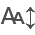

CPU times: total: 4.72 s
Wall time: 4.73 s


In [1]:
%%time
from utils.preprocessingUtils import *
from config.configs_dataframe import *
import pandas as pd

# Função utilizada para configuração de ambiente
configurar_ambiente()

# Carrega o dataframe concatenado
df = carregar_datasets(caminho_datasets, configs_dataframe)

# Remoção de dados "pseudo-nulos" (não possuem informação relevante mas não são formalmente nulos)
filtro = (df['br'] != 0) & (df['sentido_via'] != 'Não Informado') & (df['condicao_metereologica'] != 'Ignorado')
df = df[filtro]

# Criação do atributo "frequencia"
df = calcular_frequencia_acidente(df)

# Criação do target novo
df['gravidade'] = df.apply(define_gravidade, axis=1)

# Mantém apenas as colunas úteis
manter = ['data_inversa', 'dia_semana', 'horario', 'br', 'municipio', 'tipo_acidente',
         'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
          'veiculos','latitude','longitude', 'gravidade', 'frequenciaAcidente']
df = df[manter]

# Aplica a regra para criar a coluna de feriados
df['emFeriado'] = df.apply(eh_feriado, axis=1)

# Converte a coluna 'data_inversa' e 'horario' para string para que depois possamos aplicar algumas regras nelas
df['data_inversa'] = df['data_inversa'].astype(str)
df['horario'] = df['horario'].astype(str)
df['mes'] = df['data_inversa'].str[5:7]
df['dia'] = df['data_inversa'].str[8:]
df['hora'] = df['horario'].str[:2]

# Converte colunas para int e, depois, para formato cíclico - exceto 'br'
converterInt = ['mes', 'dia', 'hora']
colunasCiclicas = ['mes', 'dia', 'hora']
df[converterInt] = df[converterInt].astype(int)

# Define a fase do dia com base na coluna 'hora' e, por fim, remove as colunas 'hora' e 'fase_dia'
df['fase_do_dia'] = define_fase_do_dia(df['hora'])
df.drop(columns=['hora', 'fase_dia'], axis=1, inplace=True)

# Define as features cíclicas e remove data_inversa e horario
valores = [12, 31]
df = converte_features_ciclicas(df, colunasCiclicas, valores)
df.drop(['data_inversa', 'horario'], axis=1, inplace=True)

# Converte os rótulos do atributo "dia_semana"
dias = {
    ('segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira'): 0,
    ('sábado', 'domingo'): 1}
df['finalDeSemana'] = df['dia_semana'].apply(mapeador(dias))

# Remove colunas com outliers:
colunasComOutliers = ['veiculos']
df = remove_outliers(df, colunasComOutliers)

# Realiza agrupamento de tipos com base na condição metereológica no momento do acidente
# 1. Substitui 'Ignorado' pelo rótulo mais comum da feature
df['condicao_metereologica'] = df['condicao_metereologica'].replace('Ignorado', 'Céu Claro')

# 2. Dicionário elaborado para agrupar os tipos e ser usado na função abaixo
condicao_metereologica = {
    ('Céu Claro', 'Sol'): 'Boa',
    ('Garoa/Chuvisco', 'Nublado', 'Vento'): 'Média',
    ('Chuva', 'Nevoeiro/Neblina'): 'Ruim'
}

# 3. Aplicação da função 'mapeador' com 'condicao_metereologica' sendo passada como argumento
df['condicao_metereologica'] = df['condicao_metereologica'].apply(mapeador(condicao_metereologica))

# Cria as colunas derivadas de 'tracado_via'
df = categoriza_tracado_via(df)
df.drop(columns='tracado_via', inplace=True)

# Por fim, separação entre features e target
X = df.drop(columns=['gravidade'])
y = df['gravidade']

### Segunda etapa: Pré-processamento

In [2]:
%%time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import TargetEncoder

# Instâncias das classes a serem utilizadas no código
codificador_alvo = TargetEncoder()
escalonador_coord = StandardScaler()
pca = PCA(n_components=2)
escalonador_geral = StandardScaler()
subamostrador = RandomUnderSampler()

# Divisão treino/teste com reset dos índices
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)
X_treino = X_treino.reset_index(drop=True)
X_teste = X_teste.reset_index(drop=True)
y_treino = y_treino.reset_index(drop=True)
y_teste = y_teste.reset_index(drop=True)

# Codificação das variáveis categóricas
colunas_categoricas = X_treino.select_dtypes(include=['object']).columns.tolist()
codificador_alvo.cols = colunas_categoricas  # define colunas no codificador
X_treino_codificado = codificador_alvo.fit_transform(X_treino[colunas_categoricas], y_treino)
X_teste_codificado = codificador_alvo.transform(X_teste[colunas_categoricas])
X_treino = pd.concat([X_treino.drop(columns=colunas_categoricas), X_treino_codificado], axis=1)
X_teste = pd.concat([X_teste.drop(columns=colunas_categoricas), X_teste_codificado], axis=1)

# Escalonamento apenas das coordenadas
coordenadas_treino_escalonadas = escalonador_coord.fit_transform(X_treino[['latitude', 'longitude']])
coordenadas_teste_escalonadas = escalonador_coord.transform(X_teste[['latitude', 'longitude']])

# PCA nas coordenadas
componentes_treino_pca = pca.fit_transform(coordenadas_treino_escalonadas)
componentes_teste_pca = pca.transform(coordenadas_teste_escalonadas)

# Substituição das coordenadas pelas componentes principais
X_treino[['pc_latlon_1', 'pc_latlon_2']] = componentes_treino_pca
X_teste[['pc_latlon_1', 'pc_latlon_2']] = componentes_teste_pca
X_treino = X_treino.drop(columns=['latitude', 'longitude'])
X_teste = X_teste.drop(columns=['latitude', 'longitude'])

# Escalonamento geral das demais variáveis
X_treino_escalonado = escalonador_geral.fit_transform(X_treino)
X_teste_escalonado = escalonador_geral.transform(X_teste)
X_treino = pd.DataFrame(X_treino_escalonado, columns=X_treino.columns)
X_teste = pd.DataFrame(X_teste_escalonado, columns=X_teste.columns)

# Balanceamento das classes com undersampling (somente no treino)
X_treino, y_treino = subamostrador.fit_resample(X_treino, y_treino)

# Reformatação final
X_treino = pd.DataFrame(X_treino, columns=X_treino.columns)
y_treino = pd.Series(y_treino, name=y_treino.name)


CPU times: total: 1.55 s
Wall time: 1.62 s


### Terceira etapa: Tuning de Hiperparâmetros

In [3]:
from config.modelos import *
from config.search_spaces import *
from utils.tuningUtils import *
from utils.evaluationsUtils import *

melhores_parametros = {}

for modelo in modelos:
    nome_modelo = modelo['classe'].__name__
    print(f"{'-' * 20} Teste para {nome_modelo} com {modelo['metodo']} {'-' * 20}\n")
    
    params = tunar_modelo(
        nome_modelo=modelo["nome"],
        classe_modelo=modelo["classe"],
        X_treino=X_treino,
        y_treino=y_treino,
        espaco_busca_skopt=search_spaces_skopt if modelo["metodo"] == "skopt" else None,
        espacos_busca_optuna=search_spaces_optuna if modelo["metodo"] == "optuna" else None,
        metodo=modelo["metodo"],
        n_iteracoes=1
    )
    melhores_parametros[modelo["nome"]] = params
    print("\n")

# dict contendo os modelos treinados, prontos para serem usados na avaliação
modelos_treinados = {}

for modelo in modelos:
    nome = modelo["nome"]
    classe_modelo = modelo["classe"]
    
    print(f"{'=' * 20} Avaliação do modelo: {classe_modelo.__name__} {'=' * 20}")
    
    # Instancia o modelo com os melhores hiperparâmetros
    modelo_treinado = classe_modelo(**{**melhores_parametros[nome], **modelo.get("parametros_fixos", {})})
    
    # Treina o modelo
    modelo_treinado.fit(X_treino, y_treino)
    
    # Armazena o modelo treinado
    modelos_treinados[nome] = modelo_treinado
    
    # Avalia no conjunto de teste
    avaliar_modelo(
        modelo_treinado, 
        X_teste, 
        y_teste, 
        salvar_figuras=False, 
        nomes_arquivos={'matriz': 'matriz_svm.jpg', 'roc': 'auc_roc_svm.jpg'},
        exibir_figura=False
    )

    print("\n")


-------------------- Teste para LogisticRegression com skopt --------------------

----- Tuning para LogisticRegression (skopt) iniciado ----- 17:10:12

Melhores Hiperparâmetros (skopt): {'C': 5607.275056505338, 'fit_intercept': True, 'max_iter': 1216, 'penalty': 'l1', 'solver': 'saga', 'tol': 2.4089076834871756e-06}

----- Tuning para LogisticRegression (skopt) concluído! Tempo de execução: 00:00:05 ----- 17:10:17



-------------------- Teste para DecisionTreeClassifier com optuna --------------------

----- Tuning para DecisionTreeClassifier (optuna) iniciado ----- 17:10:17

Melhores Hiperparâmetros (optuna): {'criterion': 'log_loss', 'max_depth': 95, 'min_samples_split': 33, 'min_samples_leaf': 9, 'max_features': None, 'ccp_alpha': 0.09608307317638715}

----- Tuning para DecisionTreeClassifier (optuna) concluído! Tempo de execução: 00:00:00 ----- 17:10:17



-------------------- Teste para RandomForestClassifier com optuna --------------------

----- Tuning para RandomForestClassif

### Quarta etapa: Validação cruzada

Já que a validação cruzada foi feito de forma estratificada, um novo pré processamento se tornou necessário.

------------------- validação do algoritmo logistic_regression em execução (1/7) -------------------
Resultados de Validação Cruzada:
Acurácia: Média = 0.7540, Desvio Padrão = 0.0149
AUC-ROC: Média = 0.8197, Desvio Padrão = 0.0155
Precisão:
  Classe 0: Média = 0.7360, Desvio Padrão = 0.0166
  Classe 1: Média = 0.7752, Desvio Padrão = 0.0138
Recall:
  Classe 0: Média = 0.7927, Desvio Padrão = 0.0122
  Classe 1: Média = 0.7154, Desvio Padrão = 0.0222
F1-Score:
  Classe 0: Média = 0.7632, Desvio Padrão = 0.0130
  Classe 1: Média = 0.7440, Desvio Padrão = 0.0172
Matriz de Confusão:
Média:
[[601.  157.2]
 [215.8 542.4]]
Desvio Padrão:
[[ 9.18694726  9.23904757]
 [16.80952111 16.84755175]]
------------------- validação do algoritmo decision_tree em execução (2/7) -------------------
Resultados de Validação Cruzada:
Acurácia: Média = 0.7348, Desvio Padrão = 0.0094
AUC-ROC: Média = 0.7348, Desvio Padrão = 0.0094
Precisão:
  Classe 0: Média = 0.7082, Desvio Padrão = 0.0106
  Classe 1: Média = 0

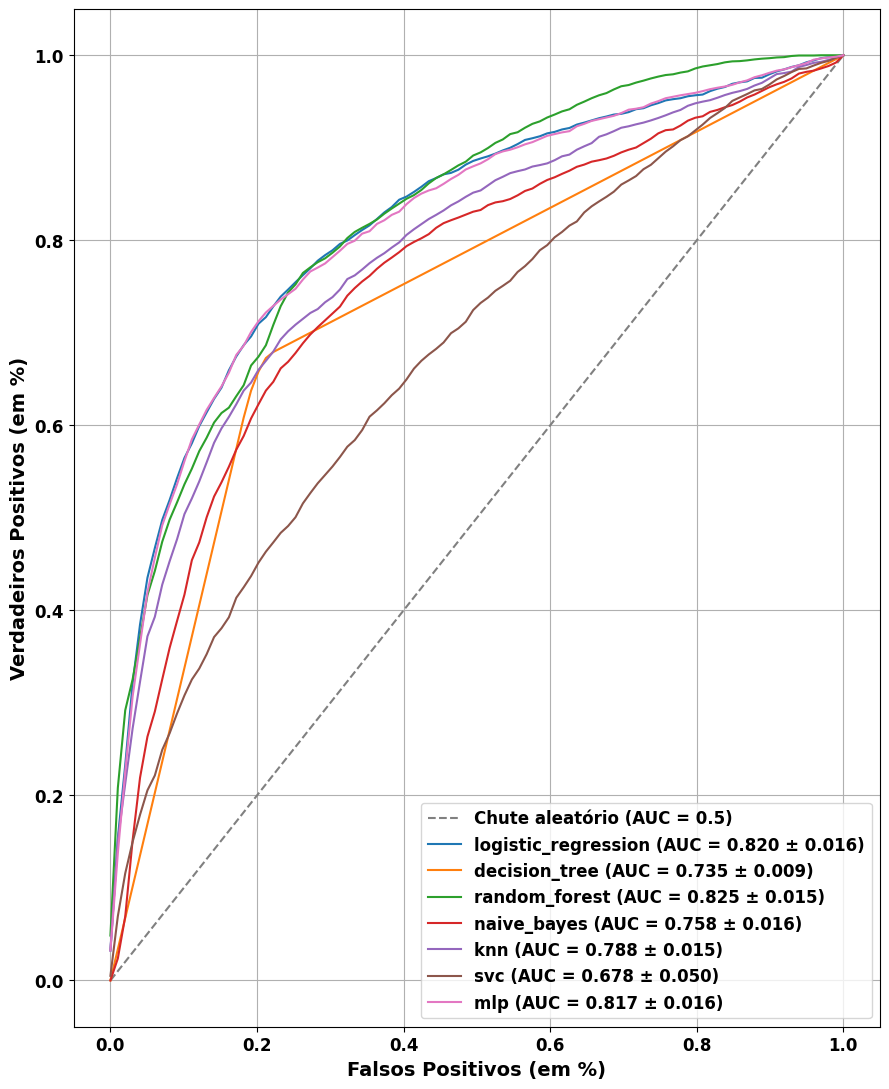

CPU times: total: 32.4 s
Wall time: 32.5 s


In [4]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import TargetEncoder

# Como os mesmos passos aqui foram feitos anteriormente, não achei necessário inserir novamente os mesmos comentários feitos antes
colunas_categoricas = X.select_dtypes(include=['object']).columns.tolist()
codificador_alvo = TargetEncoder(cols=colunas_categoricas)
escalonador_coord = StandardScaler()
pca = PCA(n_components=2)
escalonador_geral = StandardScaler()
subamostrador = RandomUnderSampler()

X_codificado = codificador_alvo.fit_transform(X[colunas_categoricas], y)
X = pd.concat([X.drop(columns=colunas_categoricas), X_codificado], axis=1)

coordenadas_escalonadas = escalonador_coord.fit_transform(X[['latitude', 'longitude']])

componentes_pca = pca.fit_transform(coordenadas_escalonadas)
X[['pc_latlon_1', 'pc_latlon_2']] = componentes_pca
X = X.drop(columns=['latitude', 'longitude'])

X_escalonado = escalonador_geral.fit_transform(X)
X = pd.DataFrame(X_escalonado, columns=X.columns)

X_balanceado, y_balanceado = subamostrador.fit_resample(X, y)

X = pd.DataFrame(X_balanceado, columns=X.columns)
y = pd.Series(y_balanceado, name=y.name)

# Seta flag para exibição da Figura 5 (AUC-ROC)
exibir_AUC_ROC = True
n = 1

# Inicializa a figura da Curva ROC, se necessário
if exibir_AUC_ROC:
    plt.figure(figsize=(9, 11))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chute aleatório (AUC = 0.5)')

# Realização do cálculo das métricas pela validação cruzada
for nome_modelo, modelo in modelos_treinados.items():
    print(f"------------------- validação do algoritmo {nome_modelo} em execução ({n}/{len(modelos_treinados)}) -------------------")
    resultados = validador_cruzado(modelo, X, y, exibir_resultados=True)
    n += 1

    if exibir_AUC_ROC and resultados['Curva ROC'][0] is not None:
        mean_fpr, mean_tpr, std_tpr = resultados['Curva ROC']
        auc_media = resultados['AUC-ROC'][0]
        auc_std = resultados['AUC-ROC'][1]
        plt.plot(mean_fpr, mean_tpr, label=f"{nome_modelo} (AUC = {auc_media:.3f} ± {auc_std:.3f})")

# Configurações finais e exibição/salvamento da Figura 5 (se a flag estiver True)
if exibir_AUC_ROC:
    plt.xlabel("Falsos Positivos (em %)", fontsize=14, fontweight='bold')
    plt.ylabel("Verdadeiros Positivos (em %)", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    legend = plt.legend(fontsize=12)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.grid()
    plt.tight_layout()
    plt.savefig(caminho_saida_figura("Fig 5.png"))
    plt.show()

### Quinta (e última) etapa: Cálculo da importância das variáveis

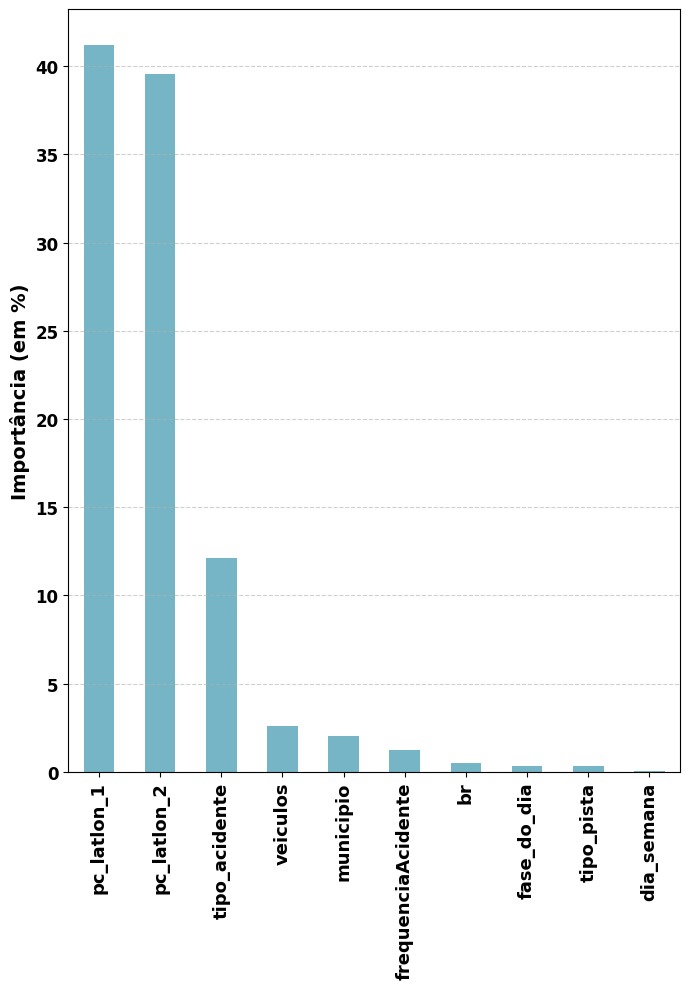

In [5]:
modelo_rf = modelos_treinados["random_forest"]
modelo_rf.fit(X, y)

importancia = pd.Series(modelo_rf.feature_importances_, index=X.columns)
importancia_percentual = 100 * importancia / importancia.sum()
importancia_percentual = importancia_percentual.sort_values(ascending=False)

plt.figure(figsize=(7, 10))
ax = importancia_percentual.head(10).plot(
    kind='bar',
    color='#76b5c5'
)
plt.ylabel("Importância (em %)", fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=13, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 6.png"))
plt.show()
